### MASKED + WEIGHTED + VARIANCE + RANDOM + SYMMETRIZATION $\kappa$ MAP

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter

In [72]:
import numpy as np

def fast_icrs_to_galactic(ra_deg, dec_deg):
    """
    Convert ICRS coordinates (RA, Dec in degrees) to Galactic (l, b in degrees)
    without using astropy. Based on standard transformation matrix.

    Parameters:
        ra_deg : float or array-like
            Right Ascension in degrees
        dec_deg : float or array-like
            Declination in degrees

    Returns:
        l_deg, b_deg : tuple of arrays
            Galactic longitude and latitude in degrees
    """
    # Convert to radians
    ra = np.radians(ra_deg)
    dec = np.radians(dec_deg)

    # Convert spherical to Cartesian
    x = np.cos(dec) * np.cos(ra)
    y = np.cos(dec) * np.sin(ra)
    z = np.sin(dec)

    # Rotation matrix from ICRS to Galactic
    R = np.array([
        [-0.0548755604, -0.8734370902, -0.4838350155],
        [ 0.4941094279, -0.4448296300,  0.7469822445],
        [-0.8676661490, -0.1980763734,  0.4559837762]
    ])

    # Apply rotation
    xg, yg, zg = np.dot(R, np.array([x, y, z]))

    # Convert back to spherical
    b_rad = np.arcsin(zg)
    l_rad = np.arctan2(yg, xg)

    # Convert to degrees
    l_deg = np.degrees(l_rad) % 360
    b_deg = np.degrees(b_rad)

    return l_deg, b_deg

In [73]:
# --- Settings ---
catalog, region = "LRG", "NGC"
real_file = f"data/eBOSS/eBOSS_{catalog}_clustering_data-{region}-vDR16.fits"
rand_file = f"data/eBOSS/eBOSS_LRG_clustering_random-{region}-vDR16.fits"
alm_file = "data/COM_Lensing_4096_R3.00/MV/dat_klm.fits"
mask_file = "data/COM_Lensing_4096_R3.00/mask.fits"

In [74]:
nside = 2048
fwhm_rad = np.radians(8 / 60)
box_size_hmpc = 100
h = cosmo.h
box_size_mpc = box_size_hmpc * h
grid_size = 100
cell_size = box_size_mpc / grid_size
half_box = box_size_mpc / 2
extent = [-box_size_hmpc/2, box_size_hmpc/2, -box_size_hmpc/2, box_size_hmpc/2]

offsets = np.linspace(-half_box + cell_size/2, half_box - cell_size/2, grid_size)
off_x, off_y = np.meshgrid(offsets, offsets)
off_x, off_y = off_x.ravel(), off_y.ravel()

In [75]:
# --- Load κ map and mask ---
alm_data = fits.open(alm_file)[1].data
alm = alm_data['REAL'] + 1j * alm_data['IMAG']
lmax = hp.Alm.getlmax(len(alm))
kmap = hp.alm2map(hp.smoothalm(alm, fwhm=fwhm_rad), nside=nside, lmax=lmax)
mask = hp.read_map(mask_file)

In [76]:
def symmetrize_map(kappa_map):
    y, x = np.indices(kappa_map.shape)
    cx, cy = grid_size // 2, grid_size // 2
    r = np.sqrt((x - cx)**2 + (y - cy)**2).astype(int)
    r_flat = r.ravel()
    kappa_flat = kappa_map.ravel()

    kappa_avg = np.bincount(r_flat, weights=kappa_flat) / np.bincount(r_flat)
    sym_map = kappa_avg[r].reshape(kappa_map.shape)
    return sym_map

In [77]:
# --- Catalog loader ---
def load_catalog(path, weights=True, random_fraction=None):
    with fits.open(path) as hd:
        cat = hd[1].data
    cat = cat[(cat['Z'] > 0) & np.isfinite(cat['RA']) & np.isfinite(cat['DEC'])]
    if random_fraction:
        cat = cat[np.random.choice(len(cat), int(random_fraction * len(cat)), replace=False)]
    w = np.ones(len(cat)) if not weights else cat['WEIGHT_NOZ'] * cat['WEIGHT_SYSTOT']
    return cat, w

In [78]:
def assign_jackknife_regions_healpix(catalog, rand_cat, nside=10, threshold=0.9):
    rand_coord = SkyCoord(ra=rand_cat['RA']*u.deg, dec=rand_cat['DEC']*u.deg)
    rand_pix = hp.ang2pix(nside, np.radians(90 - rand_coord.dec.value), np.radians(rand_coord.ra.value))

    unique, counts = np.unique(rand_pix, return_counts=True)
    mean_density = np.mean(counts)
    good_pix = unique[counts > threshold * mean_density]

    gal_coord = SkyCoord(ra=catalog['RA']*u.deg, dec=catalog['DEC']*u.deg)
    gal_pix = hp.ang2pix(nside, np.radians(90 - gal_coord.dec.value), np.radians(gal_coord.ra.value))

    mask = np.isin(gal_pix, good_pix)
    return gal_pix[mask], mask

In [79]:
def preprocess_catalog_galactic(data):
    z = data['Z']
    ra = data['RA']
    dec = data['DEC']
    D = cosmo.comoving_distance(z).value
    valid = (D > 0) & np.isfinite(D)

    ra_valid = ra[valid]
    dec_valid = dec[valid]
    D_valid = D[valid]

    l, b = fast_icrs_to_galactic(ra_valid, dec_valid)

    return l, b, D_valid, data[valid]

In [80]:
# --- κ stacker ---
def stack_kappa(data, weights, label):
    sz = grid_size**2
    sum_wk = np.zeros(sz)
    sum_wk2 = np.zeros(sz)
    sum_w = np.zeros(sz)

    # --- Preprocess only valid galaxies and convert to Galactic ---
    l_arr, b_arr, D_arr, data = preprocess_catalog_galactic(data)
    weights = weights[:len(data)]  # Ensure weights match filtered data

    for i in tqdm(range(len(data)), desc=f"Stacking {label}"):
        l = l_arr[i]
        b = b_arr[i]
        D = D_arr[i]

        dl = (off_x / D / np.cos(b)) * (180 / np.pi)
        db = (off_y / D) * (180 / np.pi)

        l_grid = l + dl
        b_grid = b + db

        theta = np.radians(90 - b_grid)
        phi = np.radians(l_grid)
        pix = hp.ang2pix(nside, theta, phi)

        w = weights[i] * mask[pix]
        if np.sum(w) == 0:
            continue

        κ_vals = kmap[pix]
        sum_wk += w * κ_vals
        sum_wk2 += w * κ_vals**2
        sum_w += w

    valid = sum_w > 0
    κ_mean = np.zeros_like(sum_w)
    κ_var = np.zeros_like(sum_w)
    κ_mean[valid] = sum_wk[valid] / sum_w[valid]
    κ_var[valid] = sum_wk2[valid] / sum_w[valid] - κ_mean[valid]**2
    κ_sigma = np.zeros_like(κ_var)
    κ_sigma[valid] = np.sqrt(κ_var[valid]) / np.sqrt(sum_w[valid])
    κ_sn = np.zeros_like(κ_mean)
    κ_sn[valid & (κ_sigma > 0)] = κ_mean[valid & (κ_sigma > 0)] / κ_sigma[valid & (κ_sigma > 0)]

    return κ_mean.reshape(grid_size, grid_size), κ_sigma.reshape(grid_size, grid_size), κ_sn.reshape(grid_size, grid_size)

In [81]:
def jackknife_stack_healpix(data, weights, rand_cat, nside=10, threshold=0.9):
    jk_regions, valid_mask = assign_jackknife_regions_healpix(data, rand_cat, nside, threshold)
    data, weights = data[valid_mask], weights[valid_mask]
    unique_regions = np.unique(jk_regions)

    kappa_jk = []

    for reg in tqdm(unique_regions, desc="Jackknife (HEALPix)"):
        mask_jk = jk_regions != reg
        data_jk = data[mask_jk]
        weights_jk = weights[mask_jk]
        kappa, _, _ = stack_kappa(data_jk, weights_jk, f"JK-{reg}")
        kappa_jk.append(kappa)

    kappa_jk = np.array(kappa_jk)
    kappa_mean = np.mean(kappa_jk, axis=0)
    kappa_err = np.sqrt((len(kappa_jk) - 1) / len(kappa_jk) * np.sum((kappa_jk - kappa_mean)**2, axis=0))

    return kappa_mean, kappa_err

In [82]:
# --- Plotting ---
def plot_map(arr, title, cmap='viridis', label='κ'):
    plt.imshow(arr, origin='lower', extent=extent, cmap=cmap)
    plt.colorbar(label=label)
    plt.xlabel("Galactic l offset (h⁻¹ Mpc)")
    plt.ylabel("Galactic b offset (h⁻¹ Mpc)")
    plt.title(title)
    plt.show()

In [83]:
def radial_profile(arr, sigma, title, zoom=70):
    y, x = np.indices(arr.shape)
    r = np.sqrt((x - grid_size/2)**2 + (y - grid_size/2)**2).astype(int)
    flat, flat_s = arr.ravel(), sigma.ravel()
    N = np.bincount(r.ravel())
    S = np.bincount(r.ravel(), weights=flat)
    S2 = np.bincount(r.ravel(), weights=flat_s**2)
    prof = S / N
    err = np.sqrt(S2) / N
    rvals = np.arange(len(prof))[:zoom]
    plt.errorbar(rvals, prof[:zoom], yerr=err[:zoom], fmt='o', capsize=3)
    plt.title(title)
    plt.xlabel("Radius (pixels)")
    plt.ylabel("κ")
    plt.grid(True)
    plt.show()

In [84]:
# --- Run all ---
data_real, w_real = load_catalog(real_file, weights=True)
data_rand, w_rand = load_catalog(rand_file, random_fraction=0.10)

# Jackknife real galaxies
kappa_real, sigma_real = jackknife_stack_healpix(data_real, w_real, data_rand, nside=10)
sn_real = np.zeros_like(kappa_real)
valid = sigma_real > 0
sn_real[valid] = kappa_real[valid] / sigma_real[valid]
kappa_rand, sigma_rand, sn_rand = stack_kappa(data_rand, w_rand, "Random")
kappa_sub = kappa_real - kappa_rand
kappa_smooth = gaussian_filter(kappa_sub, sigma=2)

Jackknife (HEALPix):   0%|          | 0/83 [00:00<?, ?it/s]

Stacking JK-94:   0%|          | 0/93580 [00:00<?, ?it/s]

Stacking JK-95:   0%|          | 0/93211 [00:00<?, ?it/s]

Stacking JK-96:   0%|          | 0/93254 [00:00<?, ?it/s]

Stacking JK-97:   0%|          | 0/93240 [00:00<?, ?it/s]

Stacking JK-98:   0%|          | 0/93335 [00:00<?, ?it/s]

Stacking JK-99:   0%|          | 0/93320 [00:00<?, ?it/s]

Stacking JK-100:   0%|          | 0/93275 [00:00<?, ?it/s]

Stacking JK-101:   0%|          | 0/93207 [00:00<?, ?it/s]

Stacking JK-102:   0%|          | 0/93508 [00:00<?, ?it/s]

Stacking JK-123:   0%|          | 0/93466 [00:00<?, ?it/s]

Stacking JK-124:   0%|          | 0/93463 [00:00<?, ?it/s]

Stacking JK-125:   0%|          | 0/93252 [00:00<?, ?it/s]

Stacking JK-126:   0%|          | 0/93252 [00:00<?, ?it/s]

Stacking JK-127:   0%|          | 0/93096 [00:00<?, ?it/s]

Stacking JK-128:   0%|          | 0/93312 [00:00<?, ?it/s]

Stacking JK-129:   0%|          | 0/93246 [00:00<?, ?it/s]

Stacking JK-131:   0%|          | 0/92945 [00:00<?, ?it/s]

Stacking JK-132:   0%|          | 0/93151 [00:00<?, ?it/s]

Stacking JK-133:   0%|          | 0/93371 [00:00<?, ?it/s]

Stacking JK-155:   0%|          | 0/93720 [00:00<?, ?it/s]

Stacking JK-156:   0%|          | 0/93446 [00:00<?, ?it/s]

Stacking JK-157:   0%|          | 0/93464 [00:00<?, ?it/s]

Stacking JK-158:   0%|          | 0/93334 [00:00<?, ?it/s]

Stacking JK-159:   0%|          | 0/93089 [00:00<?, ?it/s]

Stacking JK-160:   0%|          | 0/93199 [00:00<?, ?it/s]

Stacking JK-161:   0%|          | 0/93072 [00:00<?, ?it/s]

Stacking JK-162:   0%|          | 0/93263 [00:00<?, ?it/s]

Stacking JK-163:   0%|          | 0/93269 [00:00<?, ?it/s]

Stacking JK-164:   0%|          | 0/93261 [00:00<?, ?it/s]

Stacking JK-165:   0%|          | 0/93188 [00:00<?, ?it/s]

Stacking JK-166:   0%|          | 0/93137 [00:00<?, ?it/s]

Stacking JK-167:   0%|          | 0/93078 [00:00<?, ?it/s]

Stacking JK-168:   0%|          | 0/93178 [00:00<?, ?it/s]

Stacking JK-193:   0%|          | 0/93381 [00:00<?, ?it/s]

Stacking JK-194:   0%|          | 0/93212 [00:00<?, ?it/s]

Stacking JK-195:   0%|          | 0/93405 [00:00<?, ?it/s]

Stacking JK-196:   0%|          | 0/93185 [00:00<?, ?it/s]

Stacking JK-197:   0%|          | 0/93265 [00:00<?, ?it/s]

Stacking JK-198:   0%|          | 0/93151 [00:00<?, ?it/s]

Stacking JK-199:   0%|          | 0/93134 [00:00<?, ?it/s]

Stacking JK-200:   0%|          | 0/93225 [00:00<?, ?it/s]

Stacking JK-201:   0%|          | 0/93261 [00:00<?, ?it/s]

Stacking JK-202:   0%|          | 0/93180 [00:00<?, ?it/s]

Stacking JK-203:   0%|          | 0/93467 [00:00<?, ?it/s]

Stacking JK-204:   0%|          | 0/93246 [00:00<?, ?it/s]

Stacking JK-205:   0%|          | 0/93495 [00:00<?, ?it/s]

Stacking JK-206:   0%|          | 0/93204 [00:00<?, ?it/s]

Stacking JK-207:   0%|          | 0/93129 [00:00<?, ?it/s]

Stacking JK-208:   0%|          | 0/93729 [00:00<?, ?it/s]

Stacking JK-233:   0%|          | 0/93410 [00:00<?, ?it/s]

Stacking JK-234:   0%|          | 0/93195 [00:00<?, ?it/s]

Stacking JK-235:   0%|          | 0/93286 [00:00<?, ?it/s]

Stacking JK-236:   0%|          | 0/93204 [00:00<?, ?it/s]

Stacking JK-237:   0%|          | 0/93165 [00:00<?, ?it/s]

Stacking JK-238:   0%|          | 0/93234 [00:00<?, ?it/s]

Stacking JK-239:   0%|          | 0/93200 [00:00<?, ?it/s]

Stacking JK-240:   0%|          | 0/93216 [00:00<?, ?it/s]

Stacking JK-241:   0%|          | 0/93200 [00:00<?, ?it/s]

Stacking JK-242:   0%|          | 0/93266 [00:00<?, ?it/s]

Stacking JK-243:   0%|          | 0/93252 [00:00<?, ?it/s]

Stacking JK-244:   0%|          | 0/93352 [00:00<?, ?it/s]

Stacking JK-245:   0%|          | 0/93356 [00:00<?, ?it/s]

Stacking JK-246:   0%|          | 0/93269 [00:00<?, ?it/s]

Stacking JK-247:   0%|          | 0/93189 [00:00<?, ?it/s]

Stacking JK-248:   0%|          | 0/93374 [00:00<?, ?it/s]

Stacking JK-273:   0%|          | 0/93353 [00:00<?, ?it/s]

Stacking JK-274:   0%|          | 0/93228 [00:00<?, ?it/s]

Stacking JK-275:   0%|          | 0/93178 [00:00<?, ?it/s]

Stacking JK-276:   0%|          | 0/93285 [00:00<?, ?it/s]

Stacking JK-277:   0%|          | 0/93104 [00:00<?, ?it/s]

Stacking JK-278:   0%|          | 0/93285 [00:00<?, ?it/s]

Stacking JK-279:   0%|          | 0/93648 [00:00<?, ?it/s]

Stacking JK-281:   0%|          | 0/93697 [00:00<?, ?it/s]

Stacking JK-287:   0%|          | 0/93366 [00:00<?, ?it/s]

Stacking JK-288:   0%|          | 0/93513 [00:00<?, ?it/s]

Stacking JK-313:   0%|          | 0/93552 [00:00<?, ?it/s]

Stacking JK-314:   0%|          | 0/93415 [00:00<?, ?it/s]

Stacking JK-315:   0%|          | 0/93386 [00:00<?, ?it/s]

Stacking JK-316:   0%|          | 0/93111 [00:00<?, ?it/s]

Stacking JK-317:   0%|          | 0/93601 [00:00<?, ?it/s]

Stacking JK-353:   0%|          | 0/93439 [00:00<?, ?it/s]

Stacking JK-354:   0%|          | 0/93660 [00:00<?, ?it/s]

Stacking JK-393:   0%|          | 0/93814 [00:00<?, ?it/s]

Stacking Random:   0%|          | 0/546071 [00:00<?, ?it/s]

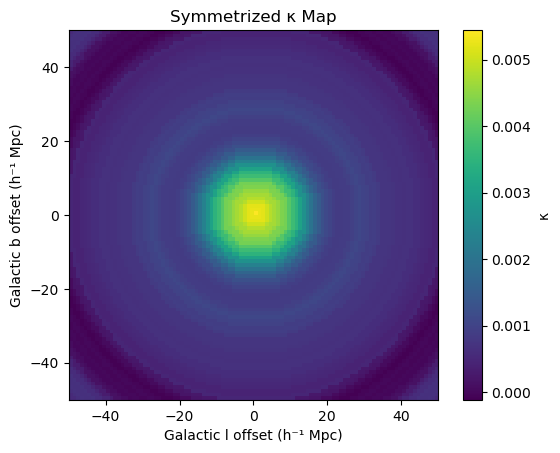

In [85]:
kappa_sym = symmetrize_map(kappa_sub)
plot_map(kappa_sym, "Symmetrized κ Map", cmap='viridis')

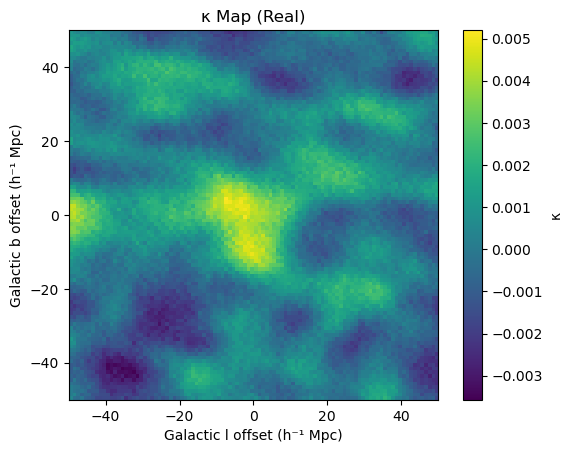

In [86]:
# --- Plots ---
plot_map(kappa_real, "κ Map (Real)")

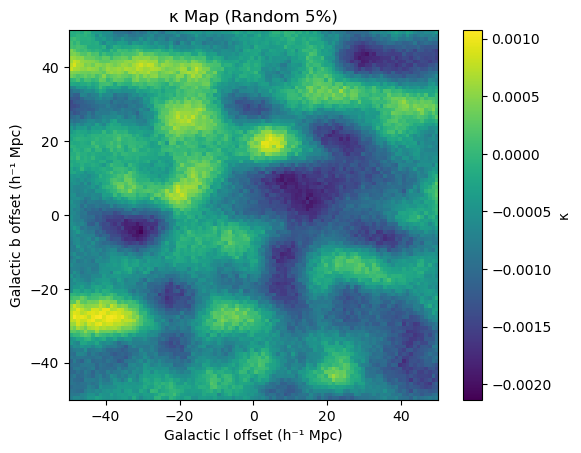

In [87]:
plot_map(kappa_rand, "κ Map (Random 5%)")

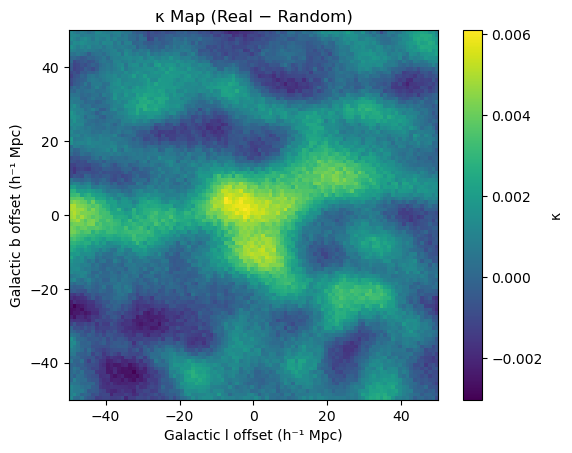

In [88]:
plot_map(kappa_sub, "κ Map (Real − Random)")

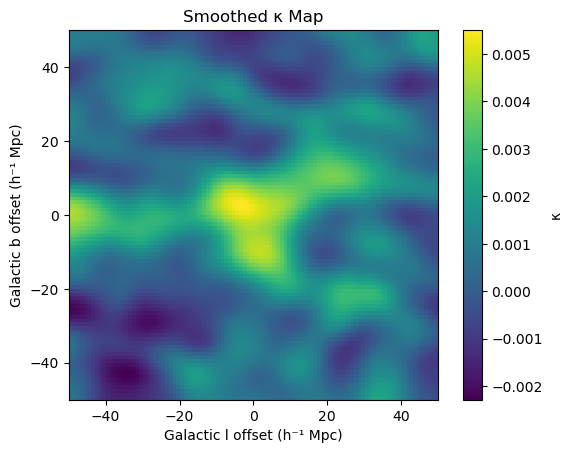

In [89]:
plot_map(kappa_smooth, "Smoothed κ Map", cmap='viridis')

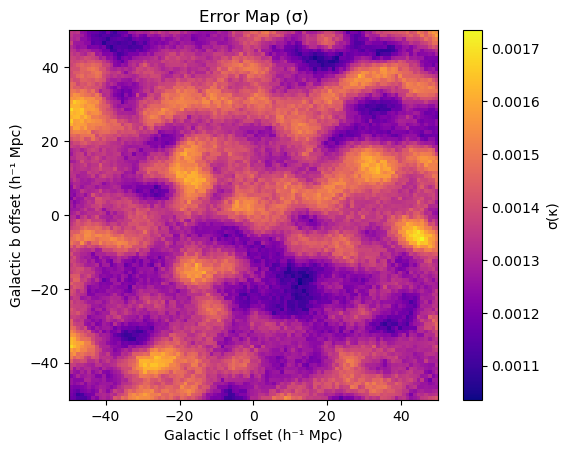

In [90]:
plot_map(sigma_real, "Error Map (σ)", cmap='plasma', label='σ(κ)')

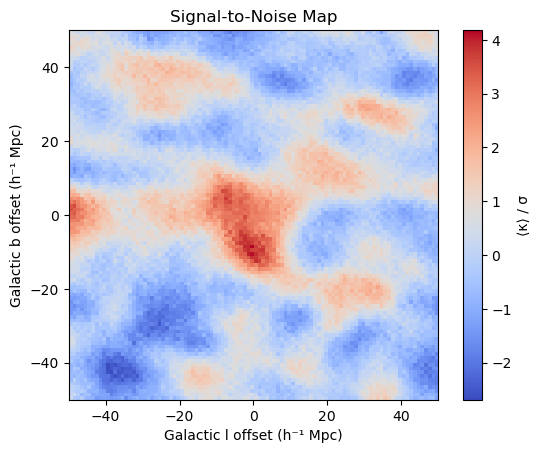

In [91]:
plot_map(sn_real, "Signal-to-Noise Map", cmap='coolwarm', label='⟨κ⟩ / σ')

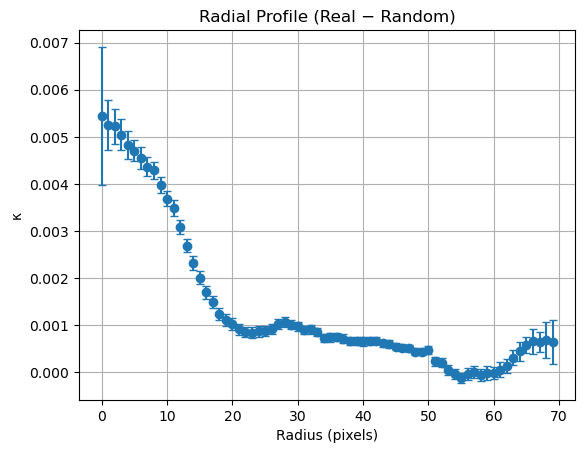

In [92]:
radial_profile(kappa_sub, sigma_real, "Radial Profile (Real − Random)", zoom=70)

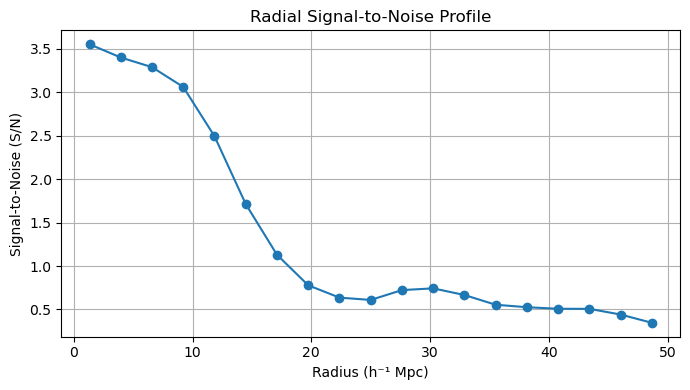

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# Use your existing stacked maps here:
kappa_mean = kappa_sub       # 2D array, shape (grid_size, grid_size)
kappa_sigma = sigma_real     # 2D array, same shape

grid_size = kappa_mean.shape[0]  # e.g. 100
box_size_hmpc = 100  # your box size in h^-1 Mpc

# Create coordinate grids in Mpc
x = np.linspace(-box_size_hmpc/2, box_size_hmpc/2, grid_size)
y = np.linspace(-box_size_hmpc/2, box_size_hmpc/2, grid_size)
X, Y = np.meshgrid(x, y)

# Compute radius from center in Mpc
R = np.sqrt(X**2 + Y**2)

# Flatten arrays for binning
r_flat = R.ravel()
signal_flat = kappa_mean.ravel()
sigma_flat = kappa_sigma.ravel()

# Define radial bins (e.g., 20 bins up to 50 Mpc)
bin_edges = np.linspace(0, box_size_hmpc/2, 20)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Digitize radii to bins
inds = np.digitize(r_flat, bin_edges)

# Compute S/N per bin
sn_profile = []
for i in range(1, len(bin_edges)):
    in_bin = (inds == i)
    if np.any(in_bin):
        mean_signal = np.mean(signal_flat[in_bin])
        mean_sigma = np.sqrt(np.mean(sigma_flat[in_bin]**2))
        sn_profile.append(mean_signal / mean_sigma if mean_sigma > 0 else 0)
    else:
        sn_profile.append(0)

# Plot radial S/N profile
plt.figure(figsize=(7,4))
plt.plot(bin_centers, sn_profile, marker='o')
plt.xlabel('Radius (h⁻¹ Mpc)')
plt.ylabel('Signal-to-Noise (S/N)')
plt.title('Radial Signal-to-Noise Profile')
plt.grid(True)
plt.tight_layout()
plt.show()

In [94]:
# --- Diagnostics ---
print("Diagnostics:")
print(f"κ min: {np.min(kappa_sub):.4g}, max: {np.max(kappa_sub):.4g}")
print(f"σ min: {np.min(sigma_real):.4g}, max: {np.max(sigma_real):.4g}")
print(f"S/N min: {np.min(sn_real):.4g}, max: {np.max(sn_real):.4g}")

Diagnostics:
κ min: -0.003035, max: 0.006092
σ min: 0.001036, max: 0.001734
S/N min: -2.691, max: 4.182
